Here we apply various matrix decompositions to a real fMRI dataset.  We will use a group fMRI dataset from a stop signal task (openfmri ds030, successful stop vs go contrast (cope6), control subjects only, n=125).

In [8]:
import os
import nibabel
import numpy
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_roi, plot_stat_map,plot_prob_atlas
from nilearn.image import index_img,smooth_img
from sklearn.decomposition import PCA, FastICA
%matplotlib inline

In [9]:
datafile='../../../data/ds030/ds030_all_stopsignal_cope6_control.nii.gz'
assert os.path.exists(datafile)
fsldir=os.environ['FSLDIR']
maskfile=os.path.join(fsldir,'data/standard/MNI152_T1_2mm_brain_mask.nii.gz')
assert os.path.exists(maskfile)
atlasfile=os.path.join(fsldir,'data/standard/MNI152_T1_2mm.nii.gz')

masker = NiftiMasker(mask_img=maskfile,smoothing_fwhm=8)
data=masker.fit_transform(datafile)
print(data.shape)


(125, 228483)


First let's run PCA on the data and look at the resulting components

In [10]:
pca=PCA(5)
pca_components=pca.fit_transform(data.T).T
print(pca_components.shape)

(5, 228483)


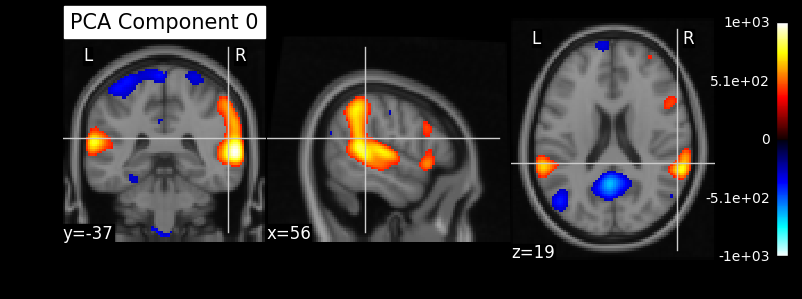

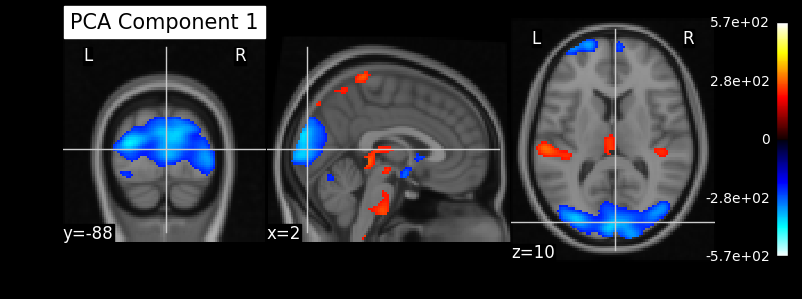

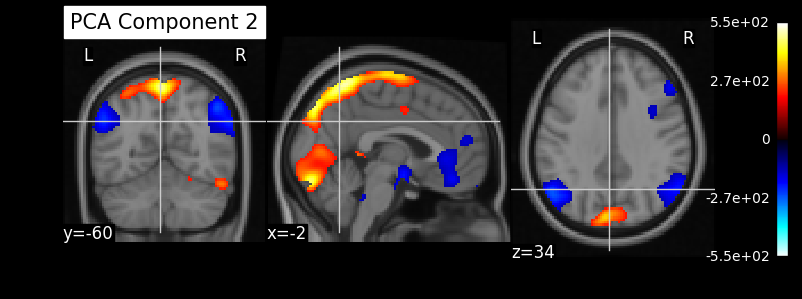

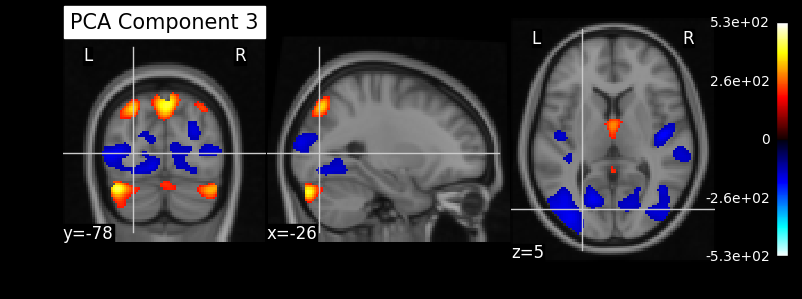

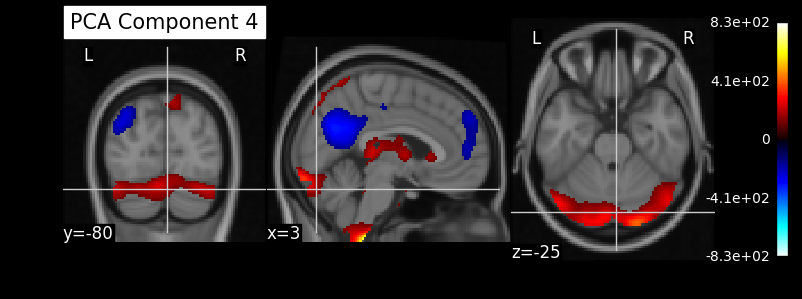

In [11]:
pca_components_img=masker.inverse_transform(pca_components)

show_pct=1  # percentage of top/bottom voxels to show

for i in range(5):
    img=index_img(pca_components_img, i)
    # clean up by setting very small values to zero
    imgdata=img.get_data()
    cutoffs=numpy.percentile(imgdata,[show_pct,100.-show_pct])
    img.dataobj[numpy.logical_and(imgdata<0,imgdata>cutoffs[0])]=0
    img.dataobj[numpy.logical_and(imgdata>0,imgdata<cutoffs[1])]=0
    plot_stat_map(img, atlasfile,threshold='auto',
              #display_mode='z', cut_coords=4, 
              title="PCA Component %d"%i)


Now let's look at the same data modeled using ICA

In [12]:
ica=FastICA(n_components=5,max_iter=10000)
components_masked = ica.fit_transform(data.T).T


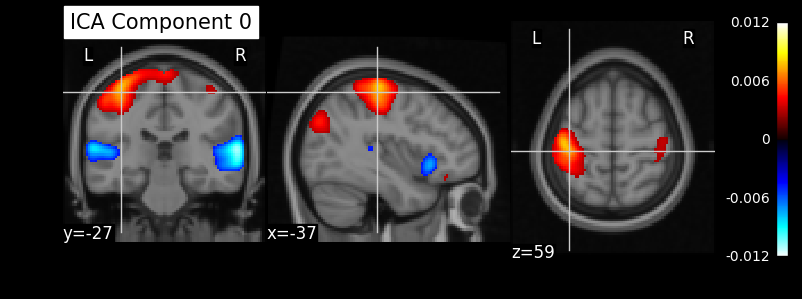

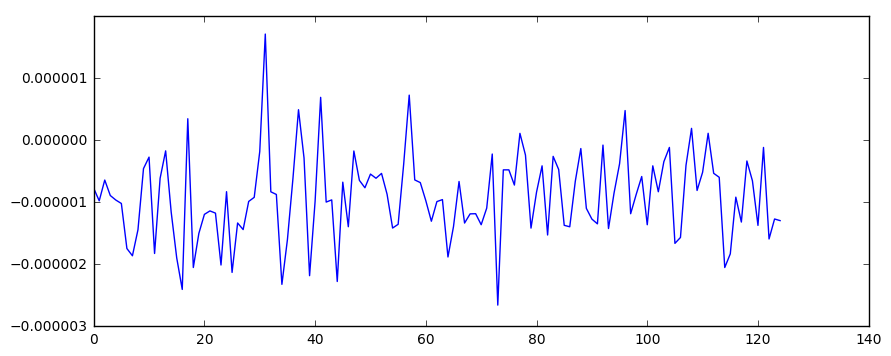

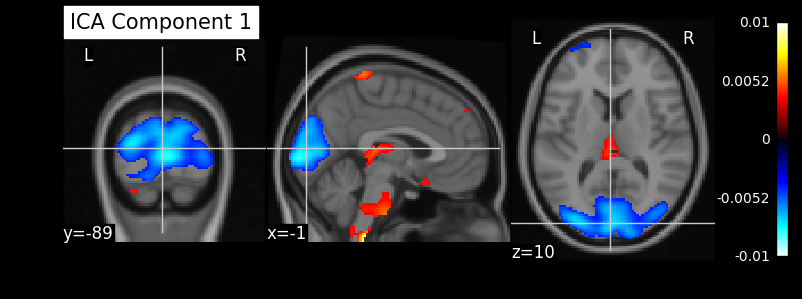

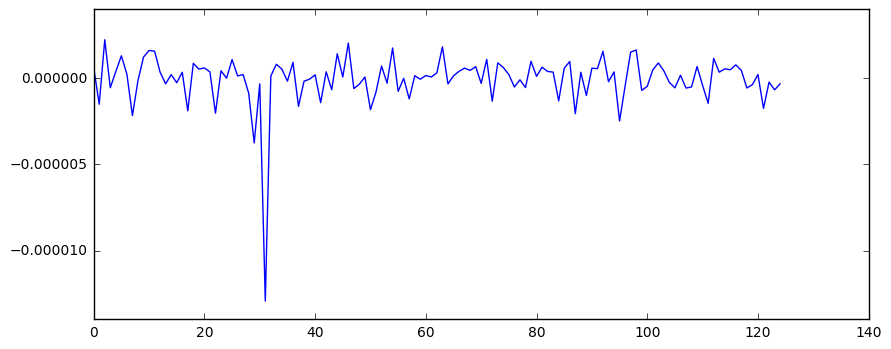

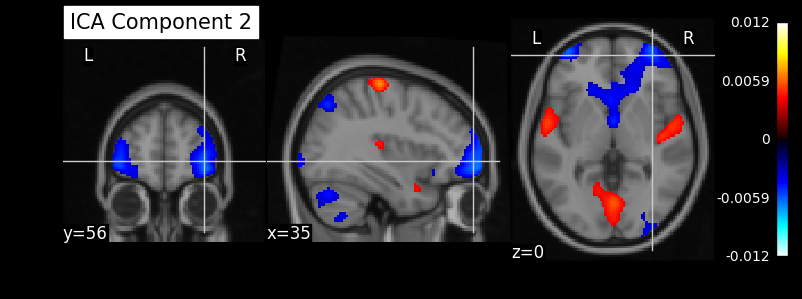

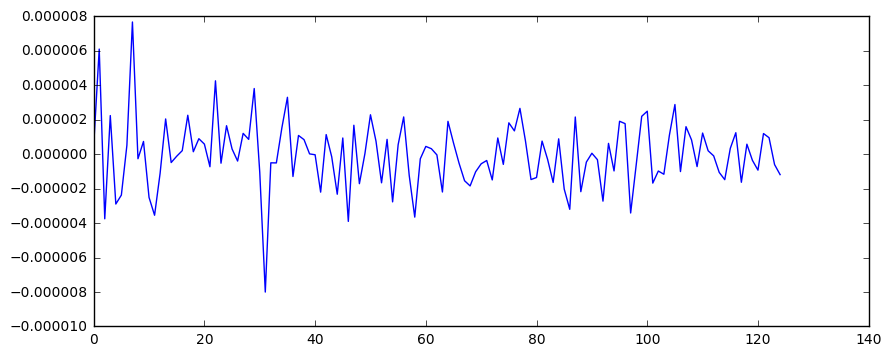

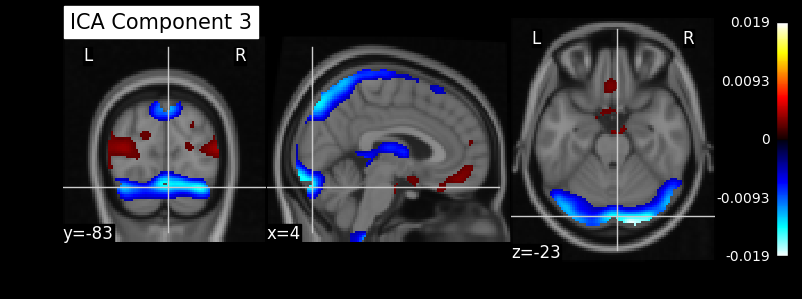

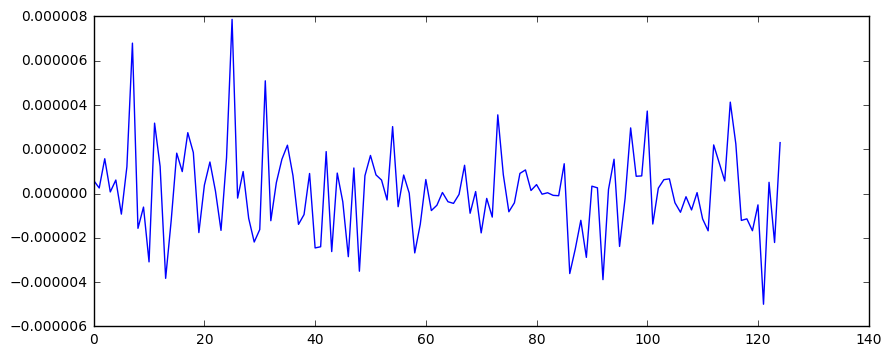

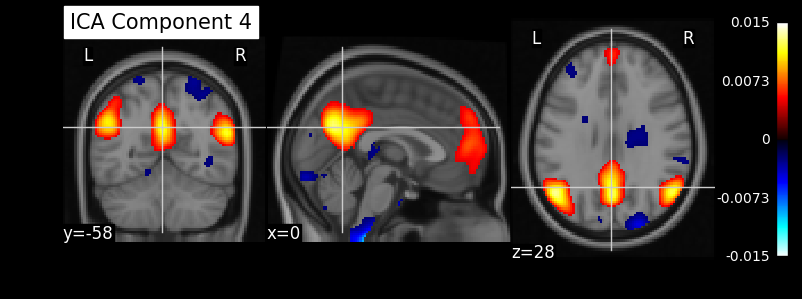

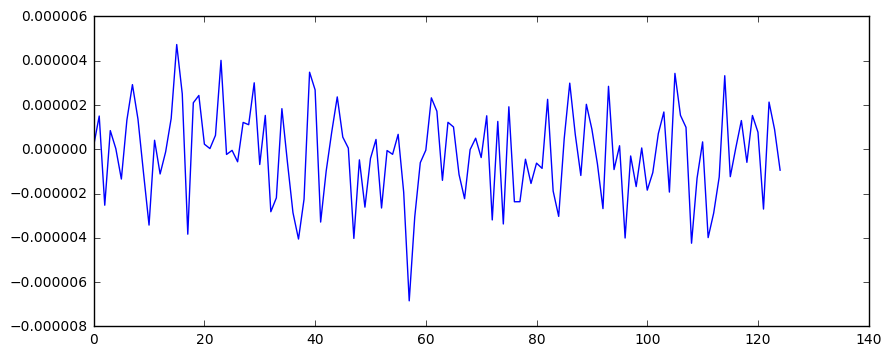

In [13]:
ica_components_img=masker.inverse_transform(components_masked)

show_pct=1  # percentage of top/bottom voxels to show

for i in range(5):
    img=index_img(ica_components_img, i)
    # clean up by setting very small values to zero
    imgdata=img.get_data()
    cutoffs=numpy.percentile(imgdata,[show_pct,100.-show_pct])
    img.dataobj[numpy.logical_and(imgdata<0,imgdata>cutoffs[0])]=0
    img.dataobj[numpy.logical_and(imgdata>0,imgdata<cutoffs[1])]=0
    
    plt.figure(figsize=(10,5))
    plot_stat_map(img, atlasfile,#threshold='auto',
              title="ICA Component %d"%i)
    plt.figure(figsize=(10,4))
    plt.plot(ica.components_[i,:])


Let's plot alongside one another to see how they differ.

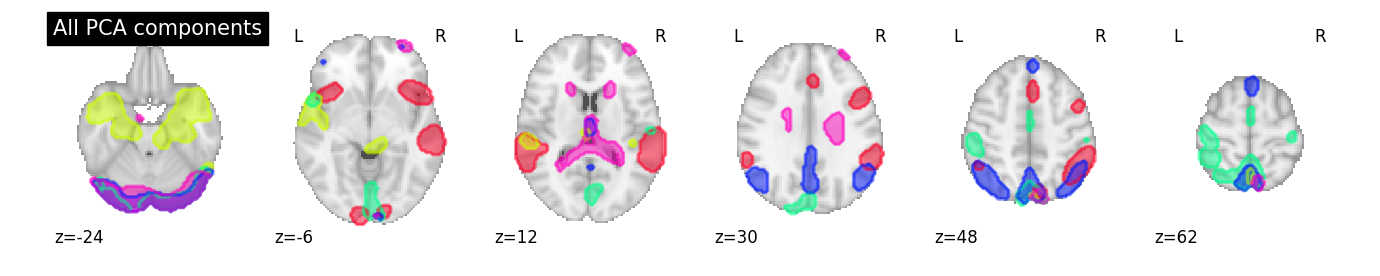

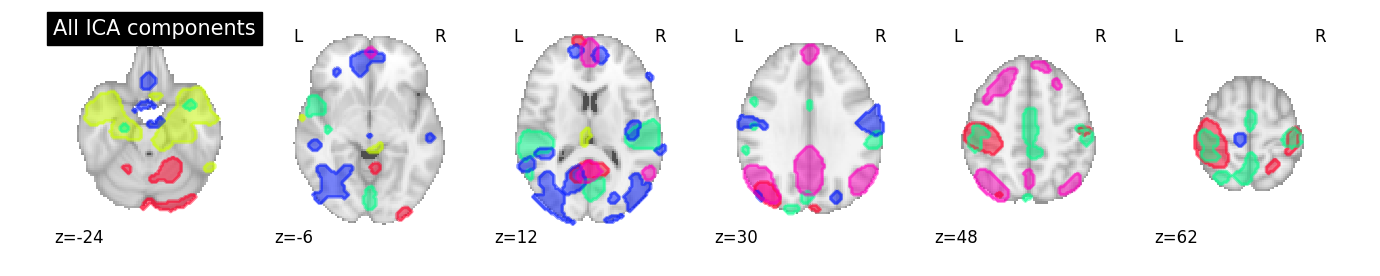

In [14]:
plot_prob_atlas(pca_components_img,title='All PCA components',view_type='filled_contours',
               display_mode='z',cut_coords=6)
plot_prob_atlas(ica_components_img,title='All ICA components',view_type='filled_contours',
                display_mode='z',cut_coords=6)
